# Improved by word2vec 

## 改进思路：1
## 加入停用词，blurb中的简介利用word2vec训练的向量替代，效果比原版提升了10%， 在15代的时候达到最好。loss=10.7, val_loss=11.8

## 改进思路：2
## 改变模型架构

In [1]:
import os, sys, re, pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from gensim.models import Word2Vec
import nltk
import math
from nltk.corpus import stopwords
print(sys.version_info)
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

from Data import Prepro_data

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
tensorflow 2.1.0
matplotlib 3.1.1
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
origin_DATA = Prepro_data.DataLoad()
origin_DATA.features.head()

,User-ID,Location,ISBN,Title,Author,Year,Publisher,Blurb
0,1582,"[4855, 6612, 1590]",6544,"[11359, 14922, 21455, 21455, 21455, 21455, 214...",14945,64,657,"[2501, 95687, 87051, 85873, 81855, 18777, 1079..."
1,1582,"[4855, 6612, 1590]",16537,"[13156, 5697, 10473, 3894, 17502, 20070, 6407,...",4601,72,767,"[7723, 67663, 25608, 53428, 36067, 90316, 9964..."
2,3489,"[1610, 693, 1590]",16537,"[13156, 5697, 10473, 3894, 17502, 20070, 6407,...",4601,72,767,"[7723, 67663, 25608, 53428, 36067, 90316, 9964..."
3,6180,"[3732, 6105, 2080]",16537,"[13156, 5697, 10473, 3894, 17502, 20070, 6407,...",4601,72,767,"[7723, 67663, 25608, 53428, 36067, 90316, 9964..."
4,3624,"[6287, 7472, 2080]",16537,"[13156, 5697, 10473, 3894, 17502, 20070, 6407,...",4601,72,767,"[7723, 67663, 25608, 53428, 36067, 90316, 9964..."


In [3]:
print(origin_DATA.blurb2vect)

0         [Here, first, time, paperback, outstanding, mi...
1         [The, fascinating, true, story, world, deadlie...
2         [The, fascinating, true, story, world, deadlie...
3         [The, fascinating, true, story, world, deadlie...
4         [The, fascinating, true, story, world, deadlie...
                                ...                        
172097    [Tory, Bauer, quintessential, diner, waitress,...
172098    [Faberville, bookstore, owner, Claire, Malloy,...
172099    [Eric, Jerome, Dickey, back, sexy, fast, paced...
172100    [Lieutenant, Horatio, Caine, leads, crack, tea...
172101    [C, est, au, travers, de, leur, correspondance...
Name: Blurb, Length: 172102, dtype: object


In [4]:
blurb_embedding_dim = 50
def load_word2vec_martics(size=blurb_embedding_dim):
    # 这里min_count会对字典做截断，如果min_coun=5,那么出现次数小于5的词会被丢弃，需要更新原本的字典
    model=Word2Vec(sentences=origin_DATA.blurb2vect,size=size,min_count=0,window=5)
    vectors = model.wv.vectors
    # 多添加了一个pad字符
    if vectors.shape[0] != len(origin_DATA.blurb2int)-1:
        print('请检查字典长度'+'\tvectors.shape = '+str(vectors.shape) + 'len(origin_DATA.blurb2int)' + str(len(origin_DATA.blurb2int)-1))
    # 得到向量矩阵
    blurb_word2vec_martics = np.zeros((len(origin_DATA.blurb2int), size))
    for i, value in origin_DATA.blurb2int.items():
         # 由于在word2vec中原句并未添加pad字符，需要将字典中的pad字符取出
        if i == '<PAD>':
            continue
        try:
            blurb_word2vec_martics[value, :] = model.wv[i]
        except:
            print(i ,value)
            print(model.wv[i])
            exit(1)
    print(blurb_word2vec_martics.shape)
    return blurb_word2vec_martics

blurb_word2vec_martics = load_word2vec_martics()

(127034, 50)


In [5]:
def pre_blurb():
    # 将blurb转换为数字矩阵，并处理长度
    pad_index = origin_DATA.blurb2int['<PAD>']
    print('pad_index = ', pad_index)
    blurb_int_list = []
    for one_blurb in origin_DATA.blurb2vect:
        # 补齐和去长
        one_blurb = one_blurb[:200]
        if len(one_blurb)< 200:
            one_blurb = one_blurb + ['<PAD>'] * (200- len(one_blurb))

        # 转化为数字列表
        temp_list = []
        for word in one_blurb:
            temp_list.append(origin_DATA.blurb2int[word])
        blurb_int_list.append(temp_list)

    blurb = np.array(blurb_int_list)
    print(blurb.shape)
    return blurb

blurb = pre_blurb()

pad_index =  28793
(172102, 200)


In [6]:
# user-id的字典,总共有28836个用户
all_user = len(set(origin_DATA.features['User-ID']))
new_user_id = {val: i for i, val in enumerate(set(origin_DATA.features['User-ID']))}
print('all user id = ', all_user)
# location的数量=7573(从0开始的)
all_location = max([j for i in origin_DATA.features.Location for j in i]) +1 
print('all location = ', all_location)

all user id =  28836
all location =  7573


In [7]:
# ISBN总数
all_isbn = len(set(origin_DATA.features['ISBN']))
print('all isbn = ', all_isbn)
# author总数
all_author = len(set(origin_DATA.features['Author']))
print('all author = ', all_author)
# year总数
all_year = len(set(origin_DATA.features['Year']))
print('all year = ', all_year)
# publish总数
all_publisher = len(set(origin_DATA.features['Publisher']))
print('all publisher = ', all_publisher)
# title中所有单词总数
all_title_words = max([j for i in origin_DATA.features.Title for j in i]) +1
print('all title words = ', all_title_words)
# blurb中所有单词总数
all_blurb_words = len(origin_DATA.blurb2int)
print('all blurb words = ', all_blurb_words)

all isbn =  38036
all author =  15196
all year =  81
all publisher =  2909
all title words =  23730
all blurb words =  127034


In [8]:
def pre_title(all_title_words=all_title_words):
    # 将title转换为数字矩阵，并处理长度
    # 对title进行补齐
    title = []
    for ti in origin_DATA.features['Title'].values:
        if len(ti) > 10:
            ti = ti[:10]
        if len(ti) < 10:
            ti = ti + [all_title_words] * (10 - len(ti))

        title.append(ti)
    all_title_words += 1
    title = np.array(title)
    return title, all_title_words

title,all_title_words = pre_title()

In [9]:
def get_train_val_test(): 
    m = len(origin_DATA.features['Location'])
    # 对location取3位数
    loca = np.zeros((m, 3))
    for i in range(m):
        loca[i] = np.array(origin_DATA.features['Location'][i])

    input_features = [origin_DATA.features['User-ID'].to_numpy(), loca, 
                      origin_DATA.features['ISBN'].to_numpy(), origin_DATA.features['Author'].to_numpy(),
                     origin_DATA.features['Year'].to_numpy(), origin_DATA.features['Publisher'].to_numpy(), 
                     title, blurb]
    labels = origin_DATA.labels.to_numpy()
    # 分割数据集以及shuffle
    np.random.seed(100)
    number_features = len(input_features)
    shuffle_index = np.random.permutation(m)
    shuffle_train_index = shuffle_index[:math.ceil(m*0.96)]
    shuffle_val_index = shuffle_index[math.ceil(m*0.96): math.ceil(m*0.98)]
    shuffle_test_index = shuffle_index[math.ceil(m*0.98):]
    train_features = [input_features[i][shuffle_train_index] for i in range(number_features)]
    train_labels = labels[shuffle_train_index]
    val_features = [input_features[i][shuffle_val_index] for i in range(number_features)]
    val_lables = labels[shuffle_val_index]
    test_features = [input_features[i][shuffle_test_index] for i in range(number_features)]
    test_lables = labels[shuffle_test_index]
    return train_features, train_labels, val_features, val_lables, test_features, test_lables

In [10]:
train_features, train_labels, val_features, val_lables, test_features, test_lables = get_train_val_test()
print(train_features[0].shape)
print(val_features[0].shape)
print(test_features[0].shape)

(165218,)
(3442,)
(3442,)


In [11]:
def get_inputs():
    # 用户特征输入
    user_id = keras.layers.Input(shape=(1,), dtype='int32', name='user_id_input')
    user_location = keras.layers.Input(shape=(3,), dtype='int32', name='user_location_input')
    
    # 书籍特征输入
    book_isbn = keras.layers.Input(shape=(1,),  dtype='int32', name='book_isbn_input')
    book_author = keras.layers.Input(shape=(1,),  dtype='int32', name='book_author_input')
    book_year = keras.layers.Input(shape=(1,),  dtype='int32', name='book_year_input')
    book_publisher = keras.layers.Input(shape=(1,),  dtype='int32', name='book_publisher_input')  
    book_title = keras.layers.Input(shape=(10, ), dtype='int32', name='book_title_input')
    book_blurb = keras.layers.Input(shape=(200, ), dtype='int32', name='book_blurb_input')
    return user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb

In [12]:
# 嵌入矩阵的维度
embed_dim = 4
embed_dim_title = 16

In [13]:
def user_embed_layer(u_id, u_loca):
    user_id_embedd = keras.layers.Embedding(all_user, embed_dim, name='user_id_embedding')(u_id)
    user_loca_embedd = keras.layers.Embedding(all_location, embed_dim , name='user_loca_embedding')(u_loca)
    return user_id_embedd, user_loca_embedd

In [14]:
def book_emded_layer(b_isbn, b_atuhor, b_year, b_publisher, b_title, b_blurb):
    book_isbn_embedd = keras.layers.Embedding(all_isbn, embed_dim, name='book_isbn_embedding')(b_isbn)
    book_author_embedd = keras.layers.Embedding(all_author, embed_dim, name='book_author_embedding')(b_atuhor)
    book_year_embedd = keras.layers.Embedding(all_year, embed_dim, name='book_year_embedding')(b_year)
    book_publisher_embedd = keras.layers.Embedding(all_publisher, embed_dim, name='book_publisher_embedding')(b_publisher)
    
    book_title_embedd = keras.layers.Embedding(all_title_words, embed_dim_title, name='book_title_embedding')(b_title)
    # 加载预训练模型
    book_blurb_embedd = keras.layers.Embedding(all_blurb_words, blurb_embedding_dim, name='book_blurb_embedding', weights=[blurb_word2vec_martics], trainable=True)(b_blurb)
    return book_isbn_embedd, book_author_embedd, book_year_embedd, book_publisher_embedd, book_title_embedd, book_blurb_embedd

In [15]:
def get_user_feature(u_id_embedd, u_loca_embedd):
    u_id_layer = keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.nn.l2_loss, name='u_id_dense')(u_id_embedd)
#     u_id_layer_drop = keras.layers.Dropout(rate=0.5, name='u_id_layer_drop')(u_id_layer)
    # u_id_layer.shape = (?, 1, 32)
    # u_loca_layer.shape = (?, 32)
    # 这里可以再加个Dense
    u_loca_layer = keras.layers.Bidirectional(tf.keras.layers.LSTM(16, name='u_loca_bilstm'), merge_mode='concat')(u_loca_embedd)
    u_loca_lstm_dense = keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.nn.l2_loss, name='u_loca_lstm_dense')(u_loca_layer)
    u_id_reshape = keras.layers.Reshape([32])(u_id_layer)
    u_combine = keras.layers.concatenate([u_id_reshape, u_loca_lstm_dense],axis=1, name='u_combine')
    print(u_combine.shape)
    # 这里能不能用激活函数
    u_feature_layer = keras.layers.Dense(100, activation='tanh', name='u_feature_layer')(u_combine)
    print(u_feature_layer.shape)
    return u_feature_layer

In [16]:
b_dense = 4
def get_book_feature(b_isbn_embedd, b_author_embedd, b_year_embedd, b_publisher_embedd, b_title_embedd, b_blurb_embedd):
    # 首先对前4个特征连接Dense层
    b_isbn_dense = keras.layers.Dense(b_dense, activation='relu', kernel_regularizer=tf.nn.l2_loss, name='b_isbn_dense')(b_isbn_embedd)
    b_author_dense = keras.layers.Dense(b_dense, activation='relu', kernel_regularizer=tf.nn.l2_loss, name='b_author_dense')(b_author_embedd)
    b_year_dense = keras.layers.Dense(b_dense, activation='relu', kernel_regularizer=tf.nn.l2_loss, name='b_year_dense')(b_year_embedd)
    b_publisher_dense = keras.layers.Dense(b_dense, activation='relu', kernel_regularizer=tf.nn.l2_loss, name='b_publisher_dense')(b_publisher_embedd)
    # 合并这四个特征,  b_combine_four shape = (?, 1, 16)
    b_combine_four = keras.layers.concatenate([b_isbn_dense, b_author_dense, b_year_dense, b_publisher_dense], name='b_four_combine')
    print('b_combine_four.shape', b_combine_four.shape)
    # 对title进行卷积
    b_title_reshape = keras.layers.Lambda(lambda layer: tf.expand_dims(layer, 3))(b_title_embedd)  # shape=(?,10, 16, 1)
    print('b_title_reshape.shape = ', b_title_reshape.shape)
    # b_title_conv.shape = 
    b_title_conv = keras.layers.Conv2D(filters=8, kernel_size=(2, embed_dim_title), kernel_regularizer=tf.nn.l2_loss, strides=1)(b_title_reshape)# shape=(?, 14, 1, 8)
    # b-title_pool.shape =
    b_title_pool = keras.layers.MaxPool2D(pool_size=(9, 1), strides=1)(b_title_conv) # shape=(?,1, 1, 8)
    print('b_title_conv.shape = ', b_title_conv)
    print('b_title_pool.shape = ', b_title_pool)
    
    # 对blurb进行处理
    # shape = 
    b_blurb_lstm_1 = keras.layers.Bidirectional(tf.keras.layers.LSTM(16, name='b_blurb_bilstm', dropout=0.5, return_sequences=True), merge_mode='concat')(b_blurb_embedd) 
    print('b_blurb_lstm_1.shape = ', b_blurb_lstm_1.shape)
    b_blurb_lstm_2 = keras.layers.LSTM(32, name='b_blurb_lstm', dropout=0.5, return_sequences=False)(b_blurb_lstm_1) 
    print('b_blurb_lstm_2.shape = ', b_blurb_lstm_2.shape)
    # 将title和blurb合并
    b_title_reshape = keras.layers.Reshape([b_title_pool.shape[3]])(b_title_pool)
    # b_combine_blurb_title.shape = 
    b_combine_blurb_title = keras.layers.concatenate([b_title_reshape, b_blurb_lstm_2], axis=1, name='b_combine_blurb_title')
    print('b_combine_blurb_title.shape = ', b_combine_blurb_title)
    b_blurb_title_dense = keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu', name='b_blurb_title_dense')(b_combine_blurb_title)
#     b_blurb_title_dense_drop = keras.layers.Dropout(rate=0.5, name='b_blurb_title_dense_drop')(b_blurb_title_dense)
    b_blurb_title_dense = keras.layers.Dense(64, activation='relu', name='b_blurb_title_dense')(b_combine_blurb_title)
    # b_combine_four_reshape shape = (?, 64)
    b_combine_four_reshape = keras.layers.Reshape([b_combine_four.shape[2]], name='b_combine_four_reshape')(b_combine_four)
    # 合并所有的书籍特征
#     b_combine_book = keras.layers.concatenate([b_combine_blurb_title, b_combine_four_reshape], axis=1, name='b_combine_book')
    b_combine_book = keras.layers.concatenate([b_blurb_title_dense, b_combine_four_reshape], axis=1, name='b_combine_book')

    # 得到书籍矩阵
    b_feature_layer = keras.layers.Dense(100, name='b_feature_layer', activation='tanh')(b_combine_book)
    return b_feature_layer

In [17]:
def get_rating(user_feature, book_feature):
#     multiply_layer = keras.layers.Lambda(lambda layer: tf.reduce_sum(layer[0]+layer[1], axis=1, keepdims=True), name = 'user_book_feature')((user_feature, book_feature))
    inference_layer = keras.layers.concatenate([user_feature, book_feature], axis=1, name='user_book_feature')
    inference_dense = tf.keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu')(inference_layer)
    multiply_layer = tf.keras.layers.Dense(1, name="inference")(inference_layer)  # inference_dense
    print(multiply_layer.shape)
    return multiply_layer

In [18]:
MODEL_DIR = './model/'

class model_network():
    def __init__(self):
        self.batchsize = 512
        self.epoch = 15
    def creat_model(self):
        user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb = get_inputs()
        user_id_embedd, user_loca_embedd = user_embed_layer(user_id, user_location)
        book_isbn_embedd, book_author_embedd, book_year_embedd, book_publisher_embedd, book_title_embedd, book_blurb_embedd = book_emded_layer(book_isbn, book_author, book_year, book_publisher, book_title, book_blurb)
        u_feature_layer = get_user_feature(user_id_embedd, user_loca_embedd)
        b_feature_layer = get_book_feature(book_isbn_embedd, book_author_embedd, book_year_embedd, book_publisher_embedd, book_title_embedd, book_blurb_embedd)
        multiply_layer = get_rating(u_feature_layer, b_feature_layer)
        model = keras.Model(inputs=[user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb],
                    outputs=[multiply_layer])
        return model
    def train_model(self):
        weights_path = './model_weights/model_2.hdf5'
#         checkpoint = keras.callbacks.ModelCheckpoint(filepath=weights_path, monitor='val_loss', mode='min', save_weights_only=True)
        model_optimizer = keras.optimizers.Adamax()
        model = self.creat_model()
        model.compile(optimizer=model_optimizer, loss=keras.losses.mse)
        history = model.fit(train_features, train_labels, validation_data=(val_features, val_lables), epochs=self.epoch, batch_size=self.batchsize, verbose=1)
        print(model.summary())
        return model, history
    def predict_model(self, model):
        test_loss = model.evaluate(test_features, test_lables, verbose=0)
        return test_loss

In [19]:
net_work = model_network()
model, history = net_work.train_model()

(None, 64)
(None, 100)
b_combine_four.shape (None, 1, 16)
b_title_reshape.shape =  (None, 10, 16, 1)
b_title_conv.shape =  Tensor("conv2d/Identity:0", shape=(None, 9, 1, 8), dtype=float32)
b_title_pool.shape =  Tensor("max_pooling2d/Identity:0", shape=(None, 1, 1, 8), dtype=float32)
b_blurb_lstm_1.shape =  (None, 200, 32)
b_blurb_lstm_2.shape =  (None, 32)
b_combine_blurb_title.shape =  Tensor("b_combine_blurb_title/Identity:0", shape=(None, 40), dtype=float32)
(None, 1)
Train on 165218 samples, validate on 3442 samples
Epoch 1/15
165218/165218 [==============================] - 30s 183us/sample - loss: 27.9865 - val_loss: 18.0682
Epoch 2/15
165218/165218 [==============================] - 22s 131us/sample - loss: 15.8154 - val_loss: 13.5997
Epoch 3/15
165218/165218 [==============================] - 22s 130us/sample - loss: 13.4013 - val_loss: 12.5264
Epoch 4/15
165218/165218 [==============================] - 22s 130us/sample - loss: 12.7281 - val_loss: 12.2179
Epoch 5/15
165218/1652

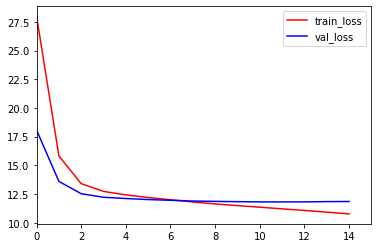

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(1)
plt.plot(train_loss, c='r', label='train_loss')
plt.plot(val_loss, c='b', label='val_loss')
plt.legend()
plt.xlim([0, 15])
# plt.ylim([0, 20])
plt.show()

In [21]:
test_loss = net_work.predict_model(model)
print(test_loss)

12.410157002521627


### 画出模型图

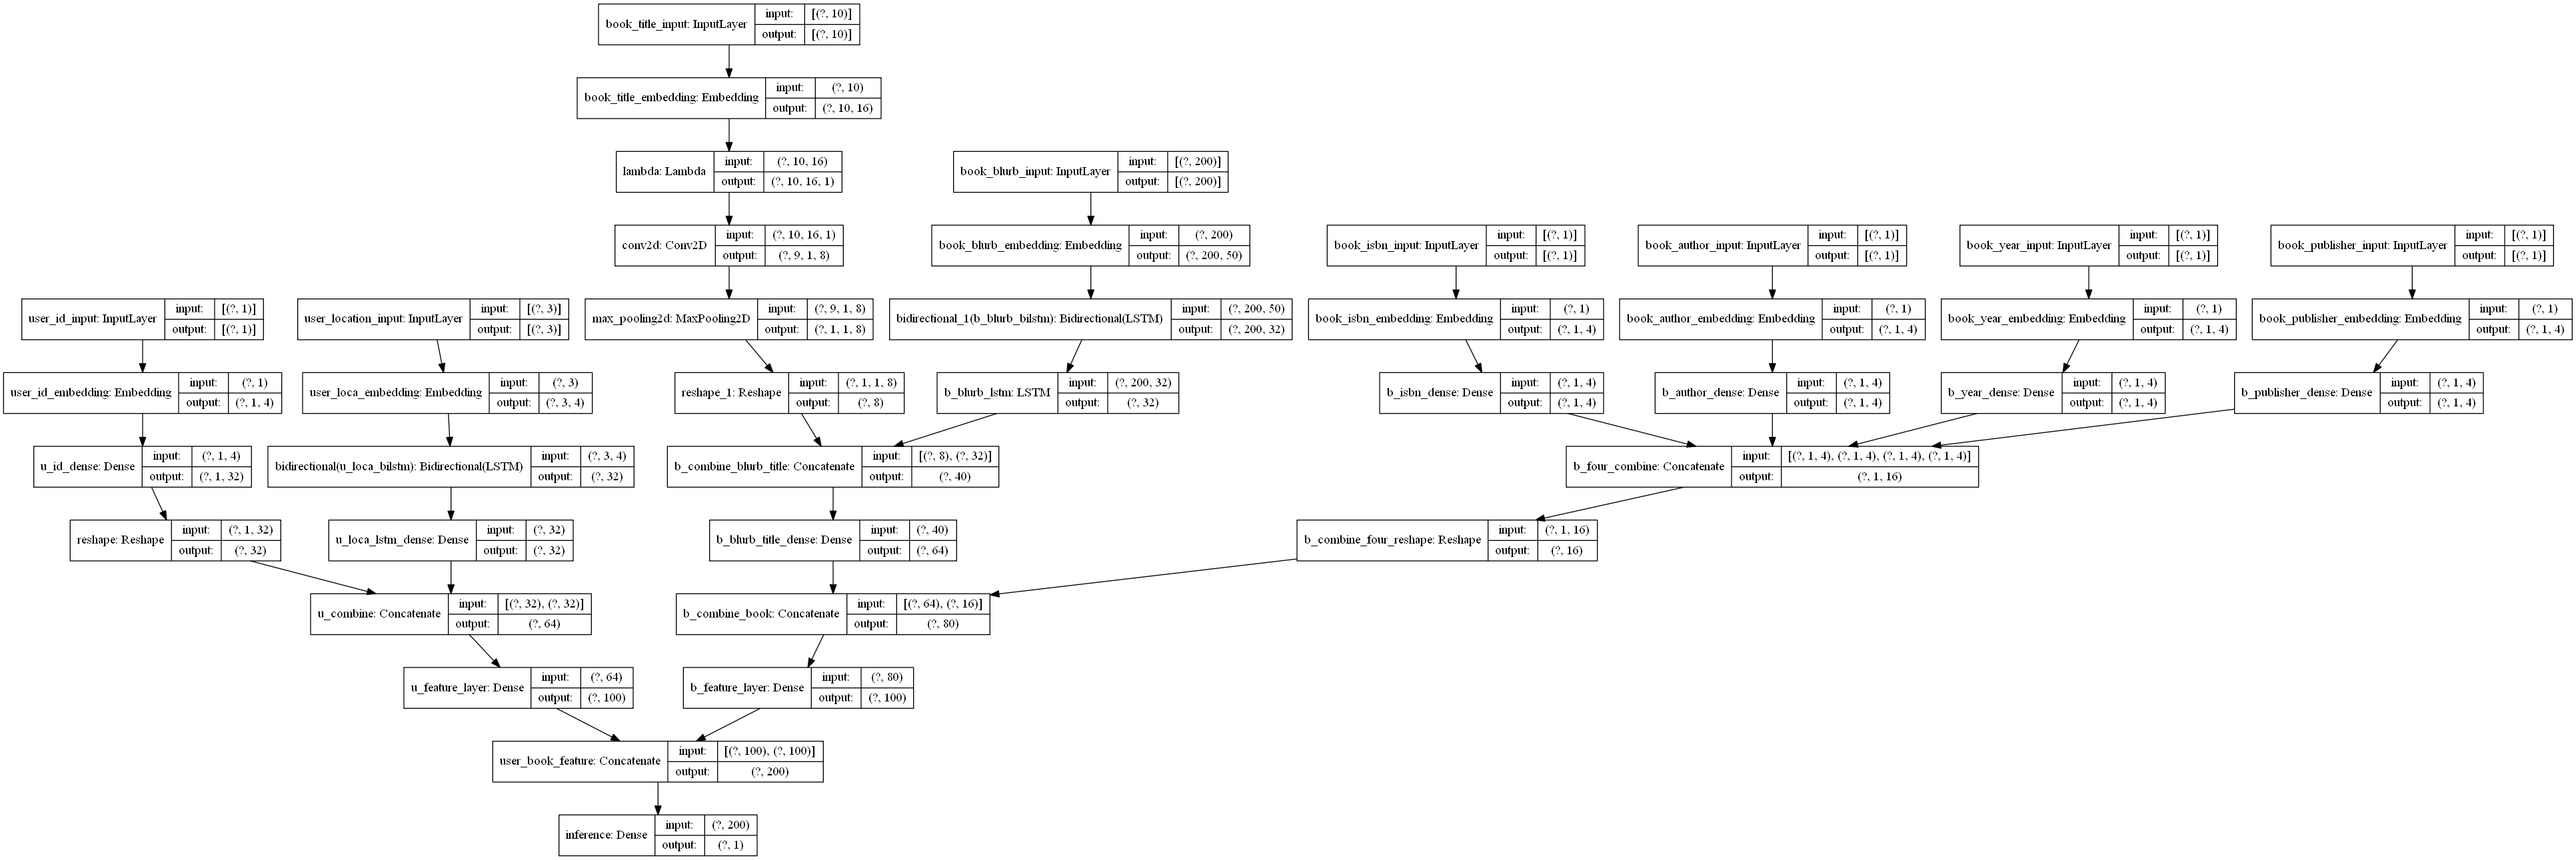

In [22]:
keras.utils.plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)